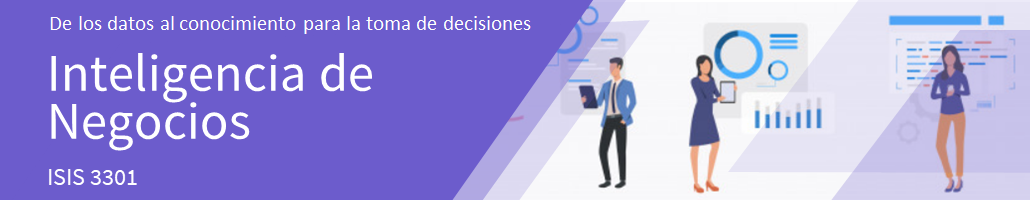

## Tarea de clasificación.

El objetivo de este notebook es mostrar cómo resolvimos la tarea de clasificación en un árbol de decisión con la librería scikit-learn.

1. Importación de librerías.
2. Carga de los datos.
3. Limpieza de los datos.
4. Implementación de Gaussian Mixture Model.
5. Interpretación del modelo.

### 1. Importación de librerías 

En las siguientes líneas de código se importan las librerías y herramientas necesarias para desarrollar el caso de uso.

In [1]:
# Librerías para manejo de datos
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
  
from sklearn.mixture import GaussianMixture

### 2. Carga de los datos
A través de la librería pandas resalizamos la carga de datos del archivo "202120_Laboratorio_2_datos_BancAlpes_credit_card_data.csv". el separador que se usará para la carga es ";".

In [2]:
# Se cargan los datos. 
df=pd.read_csv('202120_Laboratorio_2_datos_BancAlpes_credit_card_data.csv', sep=';', index_col=0)

In [3]:
# Cantidad de datos y número de variables
df.shape

(660, 10)

In [4]:
df.dtypes

Customer               object
Limit_bal              object
Sex                    object
Education              object
Marriage               object
Age                    object
Total_Credit_Cards     object
Total_visits_bank      object
Total_visits_online    object
Total_calls_made       object
dtype: object

Como podemos ver hay datos que deberían ser numéricos, pero por alguna razón estos son tipo "object".

In [5]:
# Mostrar los datos
df.head()

,Customer,Limit_bal,Sex,Education,Marriage,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Id,,,,,,,,,,
1,87073,20000,Female,2,Married,24,2,1,1,0
2,38414,120000,Female,2,Single,26,3,0,10,9
3,17341,90000,Female,2,Single,34,7,1,3,4
4,40496,50000,Female,2,Married,37,5,1,1,?
5,47437,50000,Male,2,Married,57,6,0,12,3


La razón por la que algunos datos son tipo "object", es por un error que hay en los datos, donde ciertas columnas que tienen datos numéricos poseen el caracter "-" o el caracter "?". Este caracter hace que los datos no puedan ser numéricos, por lo que es necesario deshacerse de las filas que poseen este caracter previamente mencionado.

### 3 Limpieza de los datos
Se debe hacer la exploración y limpieza de datos que no tengan sentido, no tengan datos, o no correspondan según el diccionario que nos da la empresa.

In [6]:
indexNames = df[df['Customer'] == '-'].index
df.drop(indexNames)
indexNames = df[df['Limit_bal'] == '-'].index
df.drop(indexNames)
indexNames = df[df['Sex'] == '9'].index
df.drop(indexNames)
indexNames = df[df['Sex'] == '-'].index
df.drop(indexNames)
indexNames = df[df['Marriage'] == '?'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Marriage'] == '-'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Age'] == '-'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Age'] == '2202'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Age'] == '36745'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Age'] == '789'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Total_Credit_Cards'] == '123456789'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Total_Credit_Cards'] == '-'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Total_visits_bank'] == '?'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Total_visits_bank'] == '-'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Total_visits_online'] == '-'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Total_calls_made'] == '?'].index
df.drop(indexNames, inplace=True)
indexNames = df[df['Total_calls_made'] == '-'].index
df.drop(indexNames, inplace=True)
df.shape

(649, 10)

Se corrigen errores de tipeo en los datos con los correctos

In [7]:
df["Sex"].replace({"M": "Male", "Mael": "Male"}, inplace=True)
df["Sex"].replace({"f": "Female", "F": "Female", "Femael": "Female", "Fmale": "Female"}, inplace=True)
df["Education"].replace({"-": "5", "6": "5", "ABC": "5"}, inplace=True)
df["Marriage"].replace({"0": "Others", "1": "Single", "2": "Married"}, inplace=True)
df.shape

(649, 10)

In [8]:
dl = df
dl['Customer']=dl['Customer'].astype(int)
dl['Limit_bal']=dl['Limit_bal'].astype(int)
dl['Education']=dl['Education'].astype(int)
dl['Age']=dl['Age'].astype(int)
dl['Total_Credit_Cards']=dl['Total_Credit_Cards'].astype(int)
dl['Total_visits_bank']=dl['Total_visits_bank'].astype(int)
dl['Total_visits_online']=dl['Total_visits_online'].astype(int)
dl['Total_calls_made']=dl['Total_calls_made'].astype(int)
dl.dtypes

Customer                int32
Limit_bal               int32
Sex                    object
Education               int32
Marriage               object
Age                     int32
Total_Credit_Cards      int32
Total_visits_bank       int32
Total_visits_online     int32
Total_calls_made        int32
dtype: object

Ya tenemos las columnas con los datos numéricos, excepto Sex y Marriage que son categóricas.
Lo siguiente es eliminar las columnas nulas.

In [9]:
dl.isnull().sum()

Customer               0
Limit_bal              0
Sex                    0
Education              0
Marriage               0
Age                    0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

No hay datos nulos en el Data Frame

In [10]:
dl.drop('Sex', axis=1, inplace=True)
dl.drop('Marriage', axis=1, inplace=True)
dl.shape

(649, 8)

Quitaremos las columnas de Sex y Marriage, ya que son categóricas y no sirven para generar clusters de datos.

### 4. Implementación de Gaussian Mixture Model

Para implementar GMM no es necesario estandarizar los datos debido a la optimización que hace el algoritmo por medio de covarianzas y el modelo probabilístico de distribución gaussiana.
Creamos una copia de los datos para la implementación.

In [11]:
df = dl

Al ser un modelo probabilístico, se puede recurrir a métricas como el Bayesian Information Criterion (BIC) al igual que se controla el exceso de overfitting.

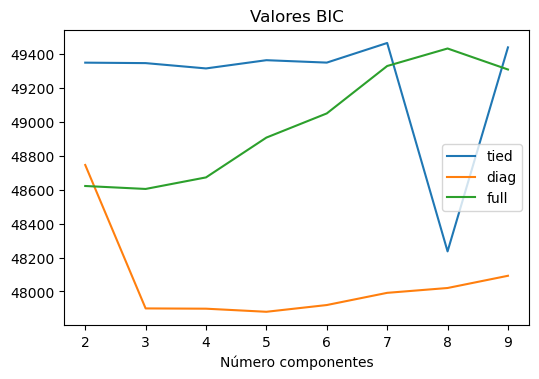

In [24]:
fig, ax = plt.subplots(figsize=(6, 3.84))

n_components = range(2, 10)
covariance_types = ['tied', 'diag', 'full']

for covariance_type in covariance_types:
    valores_bic = []
    
    for i in n_components:
        modelo = GaussianMixture(n_components=i, covariance_type=covariance_type)
        modelo = modelo.fit(df)
        valores_bic.append(modelo.bic(df))
        
    ax.plot(n_components, valores_bic, label=covariance_type)
        
ax.set_title("Valores BIC")
ax.set_xlabel("Número componentes")
ax.legend();
plt.show()

Hay que tener en cuenta que entre menor el valor de la métrica BIC, mejor.
Se decide por 3 componentes y la covarianza de tipo diagonal.

In [13]:
gmm = GaussianMixture(n_components=3, covariance_type = 'diag').fit(df)
labels = gmm.predict(df)

Se visualiza el modelo según el logarítmo de densidad de probabilidad.

D:\Users\Felipe\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Users\Felipe\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


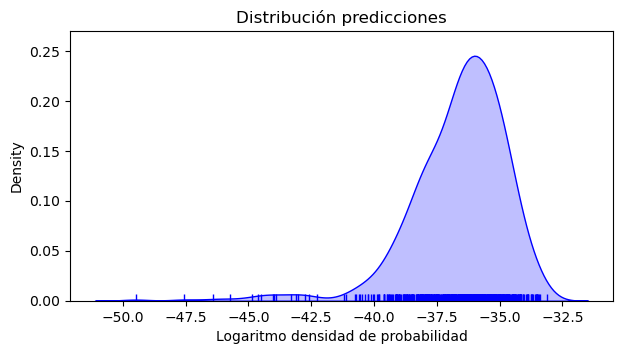

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.distplot(
    gmm.score_samples(df),
    hist    = False,
    rug     = True,
    color   = 'blue',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax
)

ax.set_title('Distribución predicciones')
ax.set_xlabel('Logaritmo densidad de probabilidad');
plt.show()

Sin embargo, esto no nos dice mucho de los datos, por lo tanto se visualiza teniendo en cuenta las variables más importantes: total de visitas online y total de llamadas.

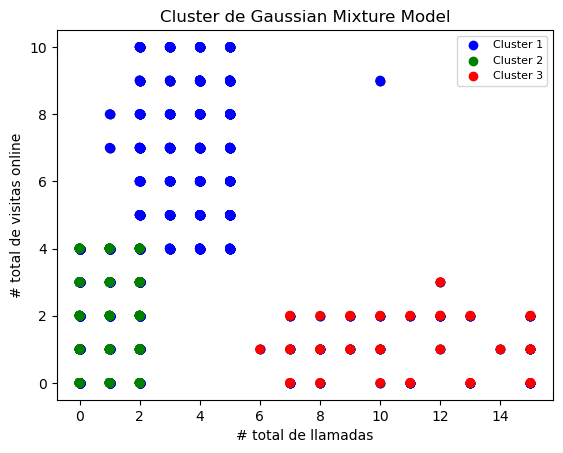

In [21]:
# Building the label to colour mapping
colors = ['r', 'g', 'b']
# Building the color vector for each data point
cvec = [colors[label] for label in labels]
#plt.scatter(df["Total_visits_online"], df["Total_calls_made"], c=labels, s=40, cmap='viridis');
b = plt.scatter(df["Total_visits_online"], df["Total_calls_made"], color ='r');
r = plt.scatter(df["Total_visits_online"], df["Total_calls_made"], color ='g');
g = plt.scatter(df["Total_visits_online"], df["Total_calls_made"], color ='b');

plt.scatter(df["Total_visits_online"], df["Total_calls_made"], c = cvec)

plt.legend((g, r, b), ('Cluster 1', 'Cluster 2', 'Cluster 3'), scatterpoints=1, loc='upper right', fontsize=8)
plt.ylabel('# total de visitas online')
plt.xlabel('# total de llamadas')
plt.title('Cluster de Gaussian Mixture Model')
plt.show()

### 5. Interpretación del modelo
Ahora vamos a revisar los resultados que nos da el modelo completado.

Primero, se revisa que el modelo haya convergido y el número de iteraciones para tener el mejor modelo:

In [16]:
print("Converge: ", gmm.converged_)
print("Número de iteraciones: ", gmm.n_iter_)

Converge:  True
Número de iteraciones:  26


Las covarianzas que hay entre cada variable:

In [17]:
gmm.covariances_

array([[7.07197661e+08, 1.50129743e+10, 4.96369117e-01, 9.07943342e+01,
        1.59250979e+00, 2.40001967e-01, 8.13383743e+00, 7.54105908e-01],
       [6.38941156e+08, 1.61798958e+10, 5.51600282e-01, 8.59582526e+01,
        1.30941620e+00, 1.30300133e+00, 7.35105839e-01, 2.04656289e+00],
       [6.86305723e+08, 1.78304618e+10, 6.97667214e-01, 8.67652411e+01,
        1.20119923e+00, 6.44085685e-01, 1.46103638e+00, 3.78503386e+00]])

Los pesos de cada cluster, es decir, la probabilidad que tiene cada cluster para tener un dato.

In [18]:
for i in range(0,3):
    print("Cluster", i+1,': ',gmm.weights_[i])

Cluster 1 :  0.07704687710365717
Cluster 2 :  0.596035810103213
Cluster 3 :  0.3269173127931301


Y las coordenadas de los centros de cada cluster.

In [19]:
for i in range(0,3):
    print("Cluster", i+1,': ',gmm.means_[i])

Cluster 1 :  [5.67062243e+04 1.60595583e+05 1.94000314e+00 3.55999029e+01
 8.73987907e+00 6.00030820e-01 1.08994525e+01 1.08018964e+00]
Cluster 2 :  [5.48839918e+04 1.70355582e+05 1.75234851e+00 3.51408084e+01
 5.50789862e+00 3.48384958e+00 9.85392913e-01 2.00161295e+00]
Cluster 3 :  [5.53440888e+04 1.71850900e+05 1.81994755e+00 3.47055855e+01
 2.39134888e+00 9.39572553e-01 3.58116426e+00 6.90820094e+00]
